# Data Exploration: Merged 3D MedMNIST Datasets

This notebook explores the **5 merged 3D MedMNIST datasets** used for hierarchical classification:
- **OrganMNIST3D**: Multi-organ CT scans (11 classes)
- **NoduleMNIST3D**: Lung nodules (2 classes: benign/malignant)
- **AdrenalMNIST3D**: Adrenal gland CT scans (2 classes)
- **FractureMNIST3D**: Rib fractures (3 classes)
- **VesselMNIST3D**: Brain vessel MRA (2 classes)

In [ ]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from config import DEVICE, DATA_CONFIG, DEFAULT_MERGED_DATASETS, set_seed
from utils.data_loader import create_hierarchical_dataset, REGION_DATASET_MAPPING

set_seed(42)
print(f"Device: {DEVICE}")

Device: cuda


<Figure size 640x480 with 0 Axes>

## 1. Load Merged Dataset

In [ ]:
# Load all 5 merged datasets
train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("="*60)
print("MERGED DATASET INFO")
print("="*60)
for key, value in dataset_info.items():
    print(f"{key}: {value}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and 

## 2. Data Distribution

In [ ]:
# Collect all labels from training set
all_coarse_labels = []
all_fine_labels = []

for imgs, coarse, fine in train_loader:
    all_coarse_labels.extend(coarse.numpy().tolist())
    all_fine_labels.extend(fine.numpy().tolist())

coarse_counts = Counter(all_coarse_labels)
fine_counts = Counter(all_fine_labels)

print("\nCoarse (Region) Distribution:")
for idx, count in sorted(coarse_counts.items()):
    region = dataset_info['idx_to_region'][idx]
    print(f"  {region} ({idx}): {count} samples ({100*count/len(all_coarse_labels):.1f}%)")

print(f"\nFine Label Distribution (top 10):")
for label, count in sorted(fine_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  Class {label}: {count} samples ({100*count/len(all_fine_labels):.1f}%)")


Coarse (Region) Distribution:
  chest (0): 2185 samples (38.5%)
  brain (1): 1335 samples (23.5%)
  multi (2): 971 samples (17.1%)
  abdomen (3): 1188 samples (20.9%)

Fine Label Distribution (top 10):
  Class 0: 3565 samples (62.8%)
  Class 1: 1202 samples (21.2%)
  Class 2: 286 samples (5.0%)
  Class 9: 115 samples (2.0%)
  Class 10: 115 samples (2.0%)
  Class 5: 94 samples (1.7%)
  Class 4: 93 samples (1.6%)
  Class 3: 91 samples (1.6%)
  Class 6: 40 samples (0.7%)
  Class 7: 39 samples (0.7%)


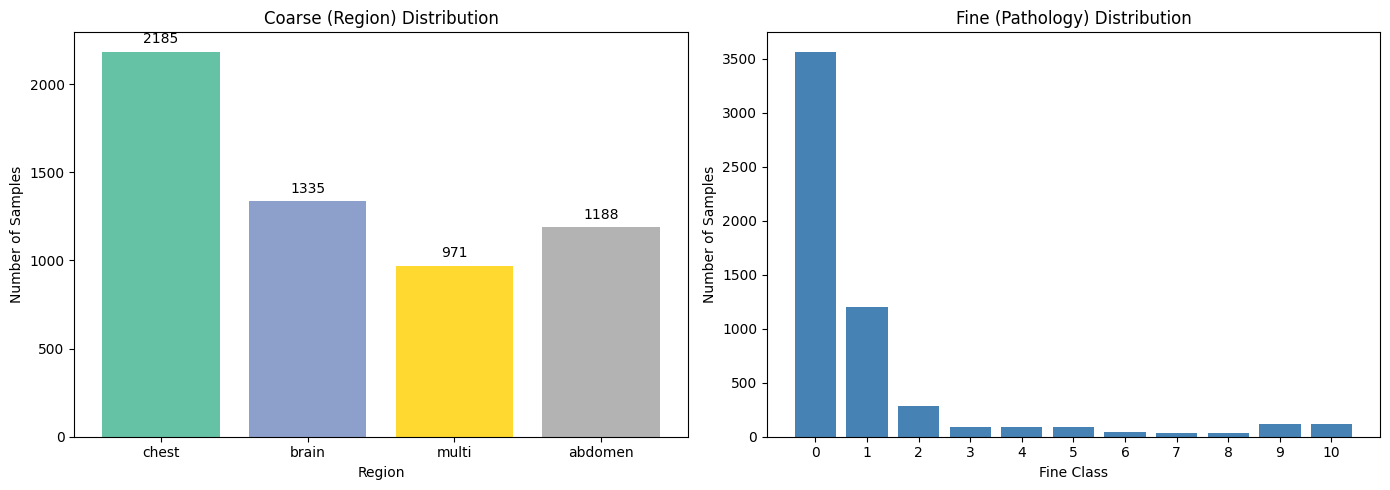

In [ ]:
# Plot coarse distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Coarse distribution
regions = [dataset_info['idx_to_region'][i] for i in sorted(coarse_counts.keys())]
counts = [coarse_counts[i] for i in sorted(coarse_counts.keys())]
colors = plt.cm.Set2(np.linspace(0, 1, len(regions)))

axes[0].bar(regions, counts, color=colors)
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Coarse (Region) Distribution')
for i, (r, c) in enumerate(zip(regions, counts)):
    axes[0].text(i, c + 50, str(c), ha='center', fontsize=10)

# Fine distribution
fine_labels_sorted = sorted(fine_counts.keys())
fine_counts_sorted = [fine_counts[l] for l in fine_labels_sorted]

axes[1].bar(range(len(fine_labels_sorted)), fine_counts_sorted, color='steelblue')
axes[1].set_xlabel('Fine Class')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Fine (Pathology) Distribution')
axes[1].set_xticks(range(len(fine_labels_sorted)))

plt.tight_layout()
plt.savefig('../figures/data_distribution.png', dpi=150)
plt.show()

## 3. Sample Visualization

In [ ]:
def visualize_3d_sample(volume, title="3D Volume", num_slices=6):
    """Visualize slices of a 3D volume."""
    if volume.ndim == 4:  # (C, D, H, W)
        volume = volume[0]  # Take first channel
    
    depth = volume.shape[0]
    slice_indices = np.linspace(0, depth-1, num_slices, dtype=int)
    
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 3))
    for i, idx in enumerate(slice_indices):
        axes[i].imshow(volume[idx], cmap='gray')
        axes[i].set_title(f'Slice {idx}')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

Visualizing samples from each region...



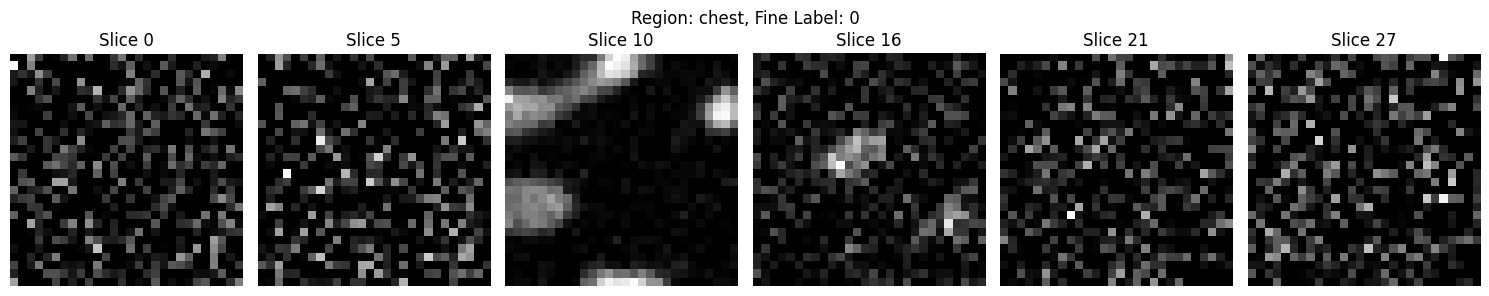

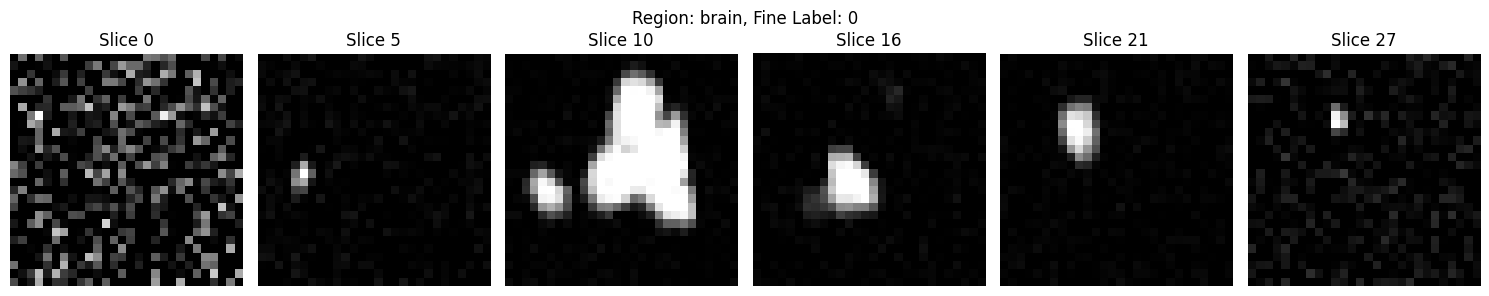

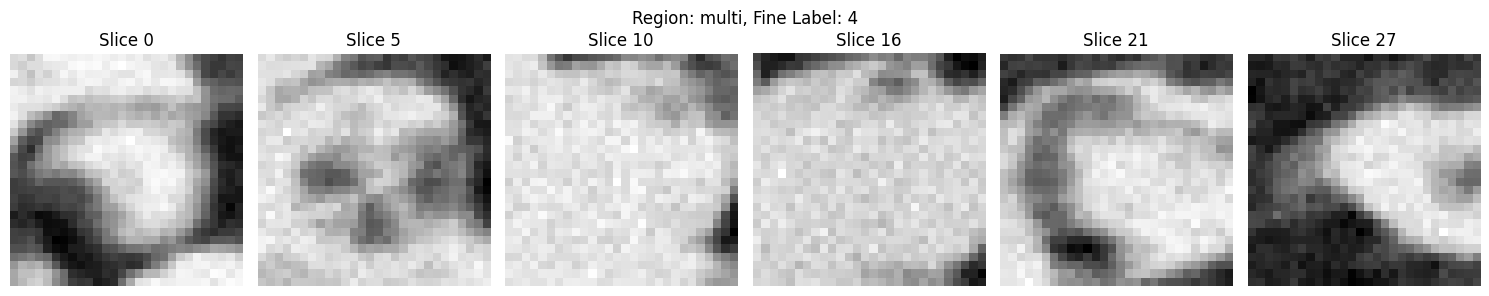

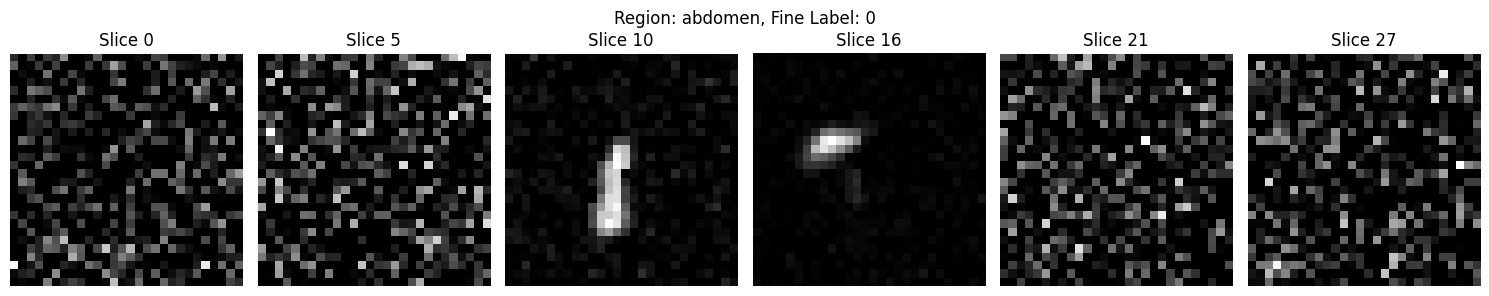

In [ ]:
# Visualize samples from each region
print("Visualizing samples from each region...\n")

region_samples = {region: None for region in dataset_info['idx_to_region'].values()}

for imgs, coarse, fine in train_loader:
    for i in range(len(imgs)):
        region_idx = coarse[i].item()
        region_name = dataset_info['idx_to_region'][region_idx]
        if region_samples[region_name] is None:
            region_samples[region_name] = (imgs[i].numpy(), fine[i].item())
    
    if all(v is not None for v in region_samples.values()):
        break

for region, (sample, fine_label) in region_samples.items():
    fig = visualize_3d_sample(sample, title=f"Region: {region}, Fine Label: {fine_label}")
    plt.show()

## 4. Volume Statistics

In [ ]:
# Compute volume statistics
print("Computing volume statistics...")

all_means = []
all_stds = []
sample_count = 0
max_samples = 500  # Limit for speed

for imgs, _, _ in train_loader:
    for img in imgs:
        img_np = img.numpy()
        if img_np.max() > 1:
            img_np = img_np / 255.0
        all_means.append(img_np.mean())
        all_stds.append(img_np.std())
        sample_count += 1
    
    if sample_count >= max_samples:
        break

print(f"\nVolume Statistics (from {sample_count} samples):")
print(f"  Mean intensity: {np.mean(all_means):.4f} ± {np.std(all_means):.4f}")
print(f"  Std intensity: {np.mean(all_stds):.4f} ± {np.std(all_stds):.4f}")

Computing volume statistics...

Volume Statistics (from 504 samples):
  Mean intensity: 0.1732 ± 0.2168
  Std intensity: 0.1426 ± 0.0682


## 5. Summary

In [ ]:
print("\n" + "="*60)
print("DATA EXPLORATION SUMMARY")
print("="*60)
print(f"\nDatasets included: {', '.join(dataset_info['datasets_included'])}")
print(f"\nSplit sizes:")
print(f"  Train: {dataset_info['train_samples']:,}")
print(f"  Val: {dataset_info['val_samples']:,}")
print(f"  Test: {dataset_info['test_samples']:,}")
print(f"\nClasses:")
print(f"  Coarse (regions): {dataset_info['num_coarse_classes']}")
print(f"  Fine (pathologies): {dataset_info['num_fine_classes']}")
print(f"\nRegion mapping: {dataset_info['idx_to_region']}")


DATA EXPLORATION SUMMARY

Datasets included: organ, nodule, adrenal, fracture, vessel

Split sizes:
  Train: 5,679
  Val: 718
  Test: 1,840

Classes:
  Coarse (regions): 4
  Fine (pathologies): 11

Region mapping: {0: 'chest', 1: 'brain', 2: 'multi', 3: 'abdomen'}
